In [1]:
from dgpsi import sexp_k_one_vector_derivative, gp, kernel, matern_k_one_vector_derivative
from mogp_emulator.ExperimentalDesign import LatinHypercubeDesign
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def k_one_vec(X,z,length,name):
    """Compute cross-correlation matrix between the testing and training input data.
    """
    if name=='sexp':
        X_l=X/length
        z_l=z/length
        L_X=np.expand_dims(np.sum(X_l**2,axis=1),axis=1)
        L_z=np.sum(z_l**2,axis=1)
        dis2=L_X-2*np.dot(X_l,z_l.T)+L_z
        k=np.exp(-dis2)
    elif name=='matern2.5':
        n=np.shape(X)[0]
        d=np.shape(X)[1]
        m=len(z)
        X_l=np.expand_dims((X/length).T,axis=2)
        z_l=np.expand_dims((z/length).T,axis=2)
        k1=np.ones((n,m))
        k2=np.zeros((n,m))
        for i in range(d):
            dis=np.abs(X_l[i]-z_l[i].T)
            k1*=(1+np.sqrt(5)*dis+5/3*dis**2)
            k2+=dis
        k2=np.exp(-np.sqrt(5)*k2)
        k=k1*k2
    return k


In [13]:

def test_f(x):
    return np.sin(2*x) + np.cos(3*x) + 0.1*np.sin(5*x)
    
def gradient_test_f(x):
    return 2*np.cos(2*x) - 3*np.sin(3*x) + 0.5*np.cos(5*x)


lhd = LatinHypercubeDesign([(-np.pi,np.pi)])

x_train = lhd.sample(15)
y_train = np.array(test_f(x_train))
gp_emu = gp(x_train, y_train, kernel(length=np.array([1]), name='matern2.5', scale_est=True))
gp_emu.train()

In [14]:
grid_eval_grid = np.linspace(-np.pi, np.pi, 100)

Z = test_f(grid_eval_grid)
grad_eval = gradient_test_f(grid_eval_grid)


pred_mu, _ = gp_emu.predict(grid_eval_grid[:,None])
# nabla_r = sexp_k_one_vector_derivative(grid_eval_grid[:,None], x_train, 
#                                 gp_emu.kernel.length, 1)
nabla_r = matern_k_one_vector_derivative(grid_eval_grid[:,None], x_train, 
                                gp_emu.kernel.length, 1)

grad_pred = np.einsum('mnd,n->md', nabla_r, gp_emu.kernel.Rinv_y)
grad_pred_var = -2*np.einsum('mdn,nk->mdk', 
                          np.transpose(nabla_r, axes=(0,2,1)), 
                          gp_emu.kernel.Rinv)
grad_pred_var = np.einsum('mdn,mn->md', grad_pred_var, 
                          k_one_vec(grid_eval_grid[:,None], x_train, 
                          gp_emu.kernel.length, gp_emu.kernel.name))

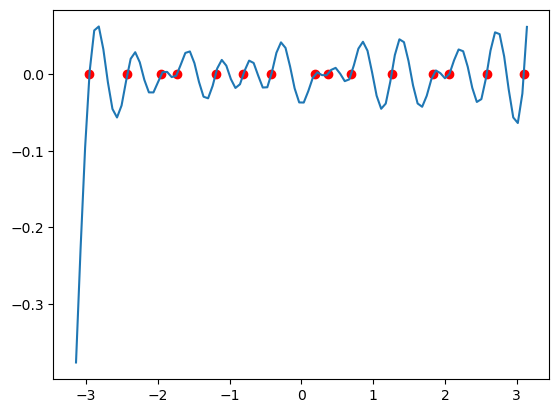

In [15]:
plt.plot(grid_eval_grid, grad_pred_var)
plt.scatter(x_train, np.zeros_like(x_train), color='red')

In [16]:
gp_emu.kernel.scale 

array([2.28853727])

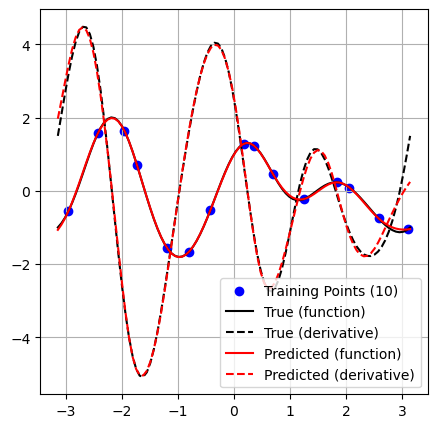

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')


ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu, color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')

plt.legend()
plt.grid()
plt.show()

In [24]:
from dgpsi import dgp, kernel, combine, lgp, path, emulator, gp, nb_seed, grad_lgp_sexp
import matplotlib.pyplot as plt
import numpy as np

In [30]:
y_train = np.array(test_f(x_train))
layer1=[kernel(length=np.array([1]),name='sexp', scale_est=False)]
        # kernel(length=np.array([1]),name='sexp', scale_est=False)]
layer2=[kernel(length=np.array([1]),name='sexp', scale_est=False)]
all_layer=combine(layer1,layer2)
m=dgp(x_train,y_train,all_layer)
m.train(N=100)
final_layer_obj=m.estimate()
# nb_seed(256)
emu=emulator(final_layer_obj,N=50)

Iteration 100: Layer 2: 100%|██████████| 100/100 [00:00<00:00, 141.99it/s]


In [31]:
pred_mu, pred_var = emu.predict(grid_eval_grid[:,None], full_layer=True)

In [34]:

grad_pred_1 = np.zeros((100, 1))
num_imp = len(emu.all_layer_set)
for i in range(num_imp):
    tmp_grad_pred, dmu_dx, dvar_dx, epsilon_xstar, d_epsilon_dz_m, d_epsilon_dz_v = grad_lgp_sexp(grid_eval_grid[:,None], 
                                emu.all_layer_set[i])
    grad_pred_1 += tmp_grad_pred/num_imp
    

dmu_dx:  0.27693907565973747
dvar_dx:  -0.004789607259988688
epsilon_xstar:  0.28941633542414336
d_epsilon_dz_m:  -0.13994392655442792
dmu_dx_2:  -0.1367548507509751
d_epsilon_dz_v:  -0.25181553982602634
first term 1:  (100, 5)
first term:  0.026416829891058428
dmu_dx:  0.27350878582939053
dvar_dx:  -0.004789607259988688
epsilon_xstar:  0.2806924908449596
d_epsilon_dz_m:  -0.13385895215859214
dmu_dx_2:  -0.13013611159661223
d_epsilon_dz_v:  -0.23185761394249085
first term 1:  (100, 5)
first term:  0.025405917776603493
dmu_dx:  0.27823583421608994
dvar_dx:  -0.004789607259988688
epsilon_xstar:  0.2773016393721048
d_epsilon_dz_m:  -0.1331348460941757
dmu_dx_2:  -0.12944170003078842
d_epsilon_dz_v:  -0.22143005841062188
first term 1:  (100, 5)
first term:  0.024878213176516038
dmu_dx:  0.2749281875806274
dvar_dx:  -0.004789607259988688
epsilon_xstar:  0.2783520042658306
d_epsilon_dz_m:  -0.13177739958833662
dmu_dx_2:  -0.12789472150899242
d_epsilon_dz_v:  -0.2268191971978393
first term 1:

In [28]:
dr = sexp_k_one_vector_derivative(pred_mu[0], emu.all_layer_set[0][1][0].input,
                             emu.all_layer_set[0][1][0].length, 1)
grad_pred_2 = np.einsum('mnd,n->md', dr, emu.all_layer_set[0][1][0].Rinv_y)


In [13]:
term_mid = d_epsilon_dz_m[:,:,0]*dmu_dx[:,:,0,0].repeat(300, axis=1)

ValueError: operands could not be broadcast together with shapes (100,15) (100,300) 

In [ ]:
term_mid = np.dot(d_epsilon_dz_m[:,:,0], emu.all_layer_set[0][1][0].Rinv_y)

In [ ]:
term_mid.shape

(100,)

In [14]:
pred_mean, pred_var = emu.predict(grid_eval_grid[:,None], full_layer=True)

In [15]:
# pred_mu, _ = gp_emu.predict(grid_eval_grid[:,None])
nabla_r = sexp_k_one_vector_derivative(pred_mean[0], emu.all_layer_set[0][1][0].input, 
                                      emu.all_layer_set[0][1][0].length, 1)


grad_pred = np.einsum('mnd,n->md', nabla_r, emu.all_layer_set[0][1][0].Rinv_y)

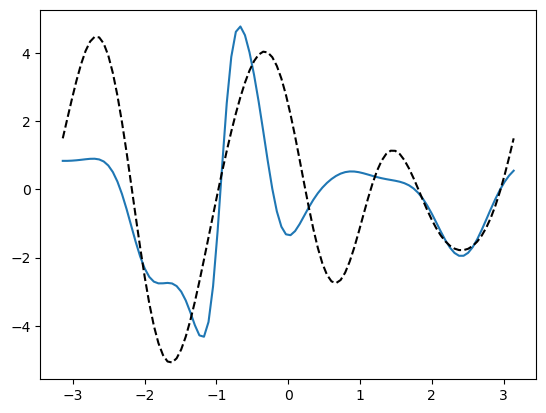

In [35]:
plt.plot(grid_eval_grid, grad_pred_1)
# plt.plot(grid_eval_grid, grad_pred_2*dmu_dx[:,:,0,0])
plt.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')
# plt.plot(grid_eval_grid, dmu_dx[:,:,0,0])


ValueError: x and y must have same first dimension, but have shapes (100,) and (2, 100, 1)

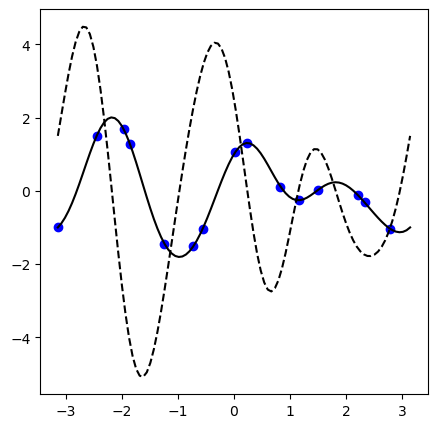

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')


ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu, color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')

plt.legend()
plt.grid()
plt.show()